In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 16.9MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
     |████████████████████████████████| 3.2MB 46.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c785be9dc368652e63e05b6079b09a00b67eaf0f0cff92a5d40ab78202d94386
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install pytorch-crf

In [ ]:
!pip install livelossplot

In [ ]:
!pip install datasets

     |████████████████████████████████| 194kB 7.8MB/s 
     |████████████████████████████████| 245kB 26.1MB/s 
     |████████████████████████████████| 112kB 15.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
dataset = load_dataset("conll2003")

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
labels = dataset['train'].features['ner_tags'].feature
num_labels = dataset['train'].features['ner_tags'].feature.num_classes
label2id = {str(id): val for id, val in enumerate(labels.names)}
id2label = {v: k for k, v in label2id.items()}
label2id

{'0': 'O',
 '1': 'B-PER',
 '2': 'I-PER',
 '3': 'B-ORG',
 '4': 'I-ORG',
 '5': 'B-LOC',
 '6': 'I-LOC',
 '7': 'B-MISC',
 '8': 'I-MISC'}

In [ ]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertPreTrainedModel, BertModel, BertForTokenClassification
from tqdm import tqdm, trange
from torchcrf import CRF
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from livelossplot import PlotLosses
from torch.utils import data 
import datetime
log_soft = F.log_softmax

In [ ]:
len(dataset['train'])

14041

In [ ]:
bert_version = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_version)

In [ ]:
bert_version = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_version)

def encode(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }


datasetn = dataset.map(encode)
datasetn.set_format(type='torch', columns=['input_ids', 'attention_mask' ,'labels'])

In [ ]:

def encode2(example):
  mask = example['attention_mask']
  return {'mask':mask}

dat = datasetn.map(encode2)

In [ ]:
dat.set_format(type='torch', columns=['input_ids', 'mask' ,'labels'])

In [ ]:
dataset = dat

In [ ]:
dataset['train']

Dataset({
    features: ['attention_mask', 'chunk_tags', 'id', 'input_ids', 'labels', 'mask', 'ner_tags', 'pos_tags', 'token_type_ids', 'tokens'],
    num_rows: 14041
})

In [ ]:
data = dict()
data['train'] = torch.utils.data.DataLoader(dataset['train'], batch_size=4)
data['validation'] = torch.utils.data.DataLoader(dataset['validation'], batch_size=4)


In [ ]:
data1 = data
model_config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)

In [ ]:

class Bert_CRF(nn.Module):
    def __init__(self, bert):
        super(Bert_CRF, self).__init__()
        self.num_labels = num_labels
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        #self.init_weights()
        self.crf = CRF(num_labels, batch_first=True)    
    
    def forward(self, input_ids, mask, labels=None):  # dont confuse this with _forward_alg above.
        outputs = self.bert(input_ids,attention_mask=mask)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        emission = self.classifier(sequence_output)        
        attn_masks = mask.type(torch.uint8)
        if labels is not None:
            loss = -self.crf(log_soft(emission, 2), labels, mask=attn_masks,reduction='mean')
            return loss
        else:
            prediction = self.crf.decode(emission,mask=attn_masks)
            return prediction

In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
def train_model(model, optimizer, num_epochs=5, batch_size=16):    
    train_loss = []
    curr_loss = {}
    global_step = 0
    model.zero_grad()
    model.train()
    training_loss = []
    validation_loss = []
    liveloss = PlotLosses()
    # for epoch in tqdmn(range(num_epochs)):

    for epoch in range(num_epochs):
        current_loss = 0
        tr_loss = 0.0
        tmp_loss = 0.0
        # for i, batch in enumerate(tqdmn(train_data)):
        for i, batch in enumerate(data['train']):
            #model.train().to(device)
            batch = { k: v.to(device) for k, v in batch.items() }
            #print(batch)
            loss = model(**batch)
            #print(loss)

          
            loss.backward()

            current_loss += loss.item()
            tmp_loss += loss.item()
            tr_loss += loss.item()
            if (i + 1) % 32 == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                training_loss.append(tr_loss/32*16)
                curr_loss['train loss'] = current_loss/(32*16)
                liveloss.update(curr_loss)
                liveloss.send()
                current_loss = 0

            if i%1000 == 0 and i>0:
                model.eval()
                validation_loss = 0
                for i, batch in enumerate(data['validation']):
                    batch = { k: v.to(device) for k, v in batch.items() }
                    outputs = model(**batch)
                    loss = outputs
                    validation_loss += loss.item()
                curr_loss['validation loss'] = validation_loss/(i*16)
                liveloss.update(curr_loss)
                liveloss.send()
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step() 


            


        
        

In [ ]:
model_config.num_labels=len(label2id)
bert = BertModel.from_pretrained(bert_version,config=model_config)
bert.config.id2label = id2label
bert.config.label2id = label2id
model = Bert_CRF(bert)
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train().to(device)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.01},
    ]
optimizer = optim.AdamW(params=optimizer_grouped_parameters, lr=3e-5,eps=1e-8)
total_steps = len(data['train']) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1, num_training_steps=total_steps)

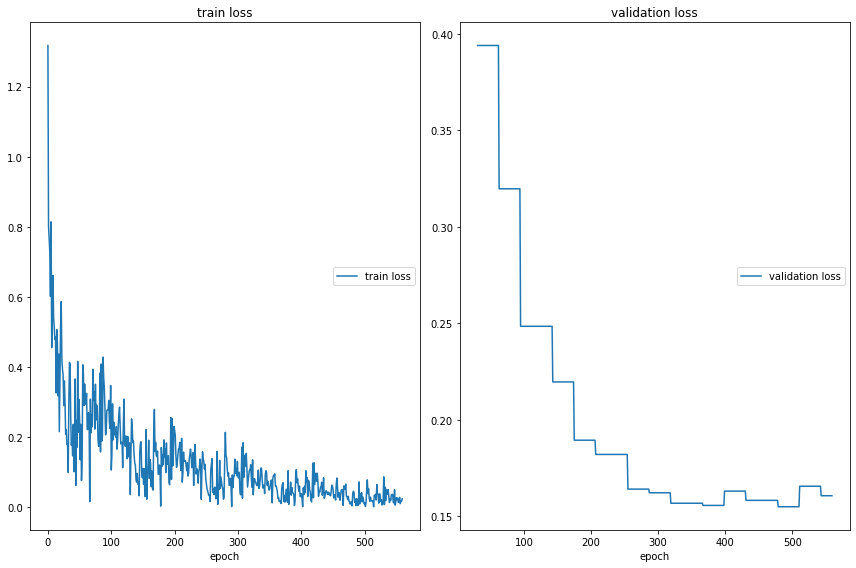

train loss
	train loss       	 (min:    0.000, max:    1.318, cur:    0.023)
validation loss
	validation loss  	 (min:    0.155, max:    0.394, cur:    0.161)


In [ ]:
train_model(model, optimizer, num_epochs=5)

In [ ]:
test_string = "He travelled to New Yorkshire".split(" ")
test_sample = [test_string]


sample = tokenizer(test_sample, truncation=True, padding='max_length', is_split_into_words=True)
s = {}
s['input_ids'] = sample['input_ids']
s['mask'] = sample['attention_mask']
#print(s)


for k, v in s.items():
  s[k] = torch.tensor(s[k])


batch = { k: v.to(device) for k, v in s.items() }
#print(batch)
outputs = model(**batch)

print(outputs)
#print(type(outputs))

[[0, 0, 0, 3, 4, 0, 0]]


In [ ]:
model = model.eval()
test_data = torch.utils.data.DataLoader(dataset['test'], batch_size=4)
#print(test_data)

confusion = torch.zeros(num_labels, num_labels)
y_true, y_pred = [], []
for batch in test_data:
        #print(batch)
        s = {}
        s['input_ids'] = batch['input_ids']
        s['mask'] = batch['mask']
        true_labels = batch['labels'].tolist()
        #print(true_labels)
        batch = { k: v.to(device) for k, v in s.items() }
        #print(batch)
        outputs = model(**batch)
        y_true.extend(true_labels)
        y_pred.extend(outputs)
        #print(outputs)
        for i in range(len(true_labels)):
          tru_string = true_labels[i]
          opt_string = outputs[i]
          for i,j in zip(tru_string,opt_string):
            confusion[i][j] += 1
        #print(confusion)
    

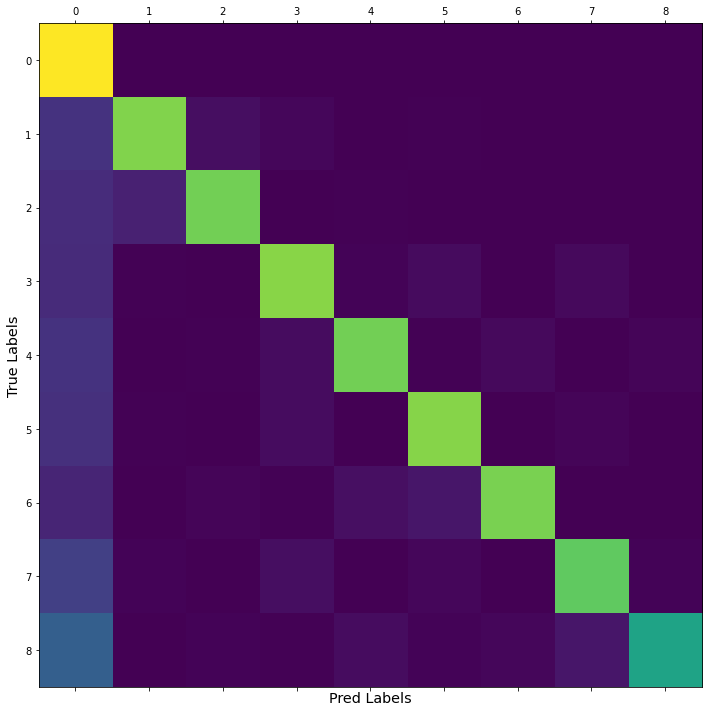

In [ ]:


for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()
  

import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))
ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')
ax.set_xticks(ids)
ax.set_xticklabels(labels)
ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
yt = MultiLabelBinarizer().fit_transform(y_true)
pt = MultiLabelBinarizer().fit_transform(y_pred)
print(metrics.classification_report(yt, pt, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3453
           1      0.981     0.952     0.966      1025
           2      0.982     0.981     0.981       720
           3      0.917     0.906     0.911      1229
           4      0.901     0.850     0.875       515
           5      0.951     0.918     0.934      1266
           6      0.827     0.850     0.839       220
           7      0.837     0.886     0.861       563
           8      0.663     0.728     0.694       162

   micro avg      0.952     0.945     0.949      9153
   macro avg      0.895     0.897     0.896      9153
weighted avg      0.953     0.945     0.949      9153
 samples avg      0.959     0.958     0.953      9153



In [ ]:
model_loc = '/content/drive/Shareddrives/SWM - NER/models/BERT_CRF/bertCRF.pth'
#torch.save(model, model_loc)

In [ ]:
ks = torch.load(model_loc)

In [ ]:
test_string = "David is an exquisite".split(" ")
test_sample = [test_string]
sample = tokenizer(test_sample, truncation=True, padding='max_length', is_split_into_words=True)
s = {}
s['input_ids'] = sample['input_ids']
s['mask'] = sample['attention_mask']
#print(s)


for k, v in s.items():
  s[k] = torch.tensor(s[k])


batch = { k: v.to(device) for k, v in s.items() }
#print(batch)
outputs = ks(**batch)
outputs = outputs[0][:len(test_string)]
print(outputs)
t = [label2id[str(i)] for i in outputs]
print(t)

[1, 0, 0, 0, 0, 0, 0]
['B-PER', 'O', 'O', 'O', 'O', 'O', 'O']


['O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']
